In [48]:
import numpy as np
import pandas as pd
import scanpy as sc
import csv
import plotly.graph_objects as go
import plotly.express as px
import os
from sklearn.decomposition import PCA

sc.settings.verbosity = 3 # verbosity:errors (0), warnings(1), info 2), hints(3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
import warnings
warnings.filterwarnings('ignore')

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.24.3 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.11.8 pynndescent==0.5.13


# Loading dataset...

In [49]:
input_matrix_path = "C:/CSE3800/Normal_6_raw/CN4/"

adata = sc.read_10x_mtx(input_matrix_path,
                        var_names='gene_symbols',
                        cache=True)

... reading from cache file cache\C-CSE3800-Normal_6_raw-CN4-matrix.h5ad


In [50]:
'''
make all genes uppercase
'''
adata.var_names = adata.var_names.str.upper()
remove_gene_list = ['AC0', 'AC1','AC2', 'AL0', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6', 'AL7', 'AL8', 'AL9', 'LINC', 'RPL', 'MT-', 'MT1', 'ERCC-', 'Gm']
remove = adata.var_names.str.startswith(remove_gene_list[0])
for gene in remove_gene_list:
    gene_remove_flags = adata.var_names.str.startswith(gene)
    remove = np.add(remove, gene_remove_flags)

keep = np.invert(remove)
adata = adata[:,keep]

remove_gene_end_list = ['Rik','Rik1','Rik2','Rik3']
remove_end = adata.var_names.str.startswith(remove_gene_list[0])
for gene in remove_gene_end_list:
    gene_remove_end_flags = adata.var_names.str.endswith(gene)
    remove_end = np.add(remove_end, gene_remove_end_flags)

keep_end = np.invert(remove_end)
adata = adata[:,keep_end]

sc.pp.filter_cells(adata, min_genes=1000) # filter cells deteced in less than 1000 genes
sc.pp.filter_genes(adata, min_cells=2000) # filter genes deteced in less than 1500 cells

sc.pp.normalize_total(adata, target_sum=60000) 
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)
# zscore_df = adata.to_df()

filtered out 503 cells that have less than 1000 genes expressed
filtered out 21992 genes that are detected in less than 2000 cells
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


# PCA Calculation - dimension reduction

In [51]:
sc.tl.pca(adata, n_comps=50) # adding a sub-dataframe with 50 PCA components added to adata

computing PCA
    with n_comps=50
    finished (0:00:01)


In [52]:
# Calculate t-SNE
sc.tl.tsne(adata, n_pcs=40) # Use only 40 PCA components for tSNE calculation

# Calculate UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) # Use only 40 PCA components for UMAP calculation
sc.tl.umap(adata)

computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:20)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [53]:
# using the leiden method to cluster the cells
sc.pp.neighbors(adata)

# sc.tl.leiden(adata, resolution = 0.2) # you can control the number of subclusters; smaller less.
sc.tl.leiden(adata, resolution = 0.3) # you can control the number of subclusters; smaller less.

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


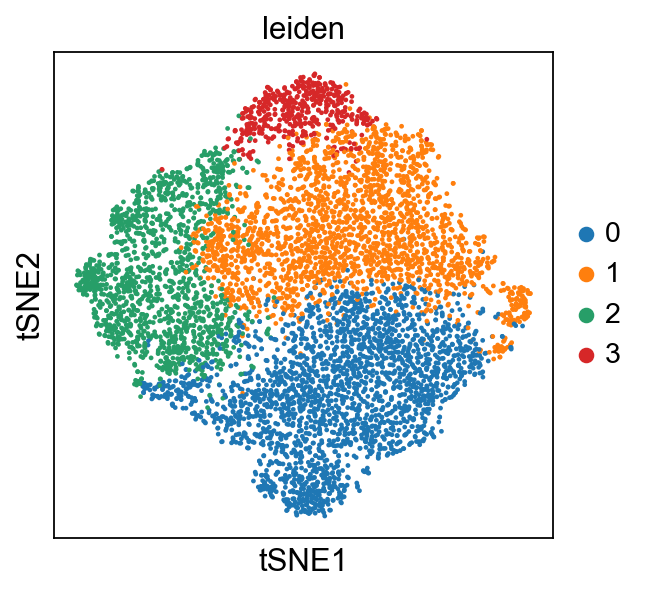

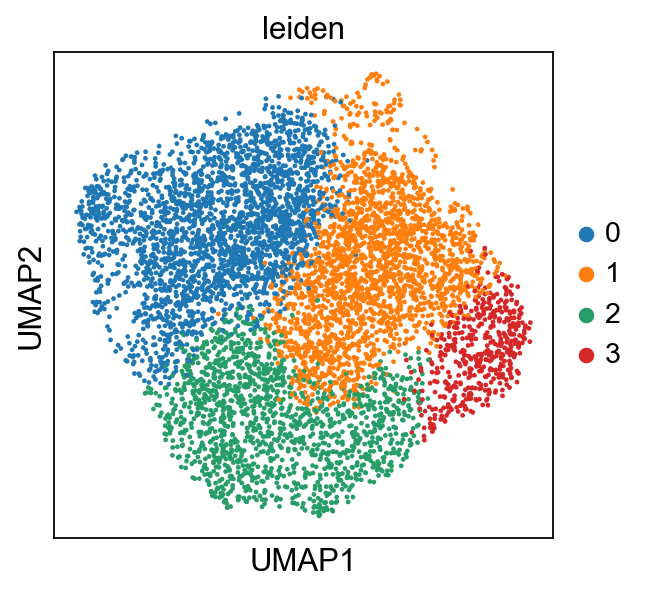

In [54]:
# Draw t-SNE and color by leiden clusters
sc.pl.tsne(adata, color='leiden')

# Draw UMAP and color by leiden clusters
sc.pl.umap(adata, color='leiden')

In [55]:
clusters = pd.unique(adata.obs['leiden'])

In [56]:
def compute_spearman (zscore):
    correlation_matrix = zscore.corr(method='spearman')
    correlation_df = pd.DataFrame(correlation_matrix)
    return correlation_df

In [57]:
def convert_square_to_pairwise (square):
    # stack pivots columns into rows and reset_index produce 3 columns.
    threecol_df = square.stack().reset_index()
    pairwise_df = threecol_df.round(3)
    pairwise_df.columns = ['GeneA', 'GeneB', 'weight']
    rightpair_df = pairwise_df[pairwise_df['GeneA'] > pairwise_df['GeneB']]
    return rightpair_df

In [58]:
def create_cluster(cluster_class):
    cluster = adata[adata.obs['leiden'] == cluster_class]
    cluster_df = compute_spearman(cluster.to_df())
    pairwise = convert_square_to_pairwise(cluster_df)
    filtered_pair = pairwise[(pairwise["weight"] > 0.3) | (pairwise["weight"] < -0.3)]
    filtered_pair = filtered_pair.reset_index(drop=True)
    
    return filtered_pair

In [59]:
directory = "C:/CSE3800/ReportData/"

for cluster in clusters:
    cluster_data = create_cluster(cluster)
    cluster_data.to_csv(directory + 'filtered' + cluster + '.csv', sep=",", index=False)